# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [6]:
using CellBasedModels
using CUDA
using Distributions
using GLMakie #Can be changes to Cairo or CLMakie
using GeometryBasics
Makie.inline!(true);

## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [7]:
rod2D = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64
        ),    #Local Interaction Parameters

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m 
        dt(vy) =  -β*vy+fy/m 
        dt(theta) =  ω 
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end
);


### Initialize a community with two bacteries and check forces

In [43]:
com = Community(rod2D,
            N=2,
            dt=0.1,
            simBox = [-20 20;-20 20.],
            neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
            platform=GPU(),
            agentAlg = CBMIntegrators.Heun()
            );

#Natural units scales
m = 1/100
g = 1/10000
d = 1
#Model constants
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
#Agent parameters
com.m = 1
com.d = 1
com.l = 3;
    # You can play to put different positions and angles here and see the behaviour of the interacting bacteries
com.x = [0.,1]
com.y = [0.,1]
com.theta = [0,π/2];

In [44]:
evolve!(com,steps=50,saveEach=1,preallocateAgents=0)

In [45]:
function CBMPlots.plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0.),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=GeometryBasics.Sphere(Point3f0(0,0,0),Float32(1)),
                markersize=[
                    Point3f0(i/2,i/2,0)
                    for i in d
                ];
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=GeometryBasics.Cylinder(Point3f0(-.5,0,0),Point3f0(.5,0,0),Float32(1)),
                markersize=[Point3f0(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotations=angle;
                kargs...
            )

    return

end


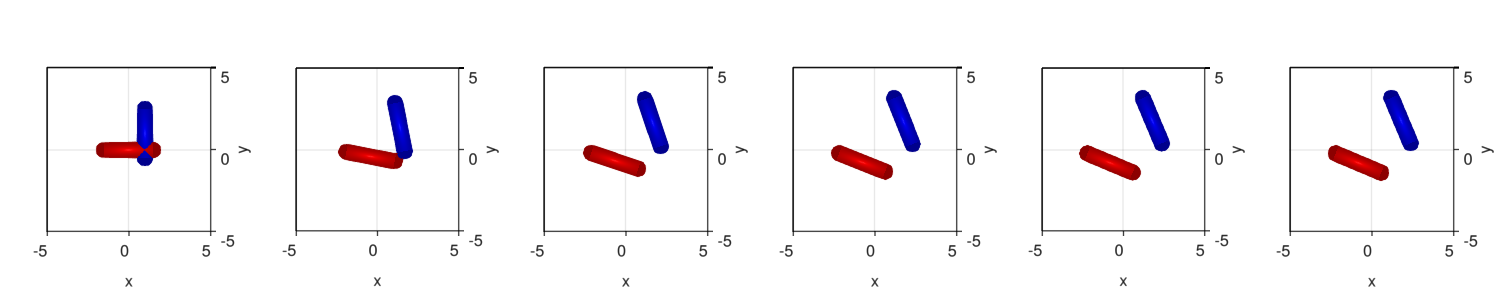

In [46]:
fig = Figure(resolution=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    CBMPlots.plotRods2D!(ax,com[j][:x],com[j][:y],com[j][:d],com[j][:l],com[j][:theta],color=[:red,:blue])
    xlims!(-5,5)
    ylims!(-5,5)
end

display(fig)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [47]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64
            ),

    agentODE = quote
        dt(l) = growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1) #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    ω = -ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget) #New target length at which the bactery should divide
                    )
            #Remove the old cell
            @removeAgent()
        end
    end,
);

## Grow colony from one cell

In [56]:
com = Community(rods2dGrowth,
            N=1,
            dt=0.1,
            simBox = [-100 100;-100 100.],
            neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
            platform=GPU(),
            agentAlg=CBMIntegrators.Heun()
            );

m = 1/100
g = 1/10000
d = 1
com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.growth = 1E-6 * (sqrt(g*d)) *100000
com.lMax = 3.     
com.σlTarget = .2 
com.α = 50

com.m = 1.        
com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.x = 0
com.y = 0
com.theta = 0;

In [57]:
evolve!(com,
        steps=150000,saveEach=1000,
        preallocateAgents=1000,
        saveCurrentState=true,
        progressMessage=(com)->if round(Int,com.t/com.dt)%10000 == 0; println("Step: ",round(Int,com.t/com.dt), " N: ", com.N); end)

Step: 1000


Step: 2000


Step: 3000


Step: 4000


Step: 5000


Step: 6000


Step: 7000


Step: 8000


Step: 9000


Step: 10000


Step: 11000


Step: 12000


Step: 13000


Step: 14000


Step: 15000


Step: 16000


Step: 17000


Step: 18000


Step: 19000


Step: 20000


Step: 21000


Step: 22000


Step: 23000


Step: 24000


Step: 25000


Step: 26000


Step: 27000


Step: 28000


Step: 29000


Step: 30000


Step: 31000


Step: 32000


Step: 33000


Step: 34000


Step: 35000


Step: 36000


Step: 37000


Step: 38000


Step: 39000


Step: 40000


Step: 41000


Step: 42000


Step: 43000


Step: 44000


Step: 45000


Step: 46000


Step: 47000


Step: 48000


Step: 49000


Step: 50000


Step: 51000


Step: 52000


Step: 53000


Step: 54000


Step: 55000


Step: 56000


Step: 57000


Step: 58000


Step: 59000


Step: 60000


Step: 61000


Step: 62000


Step: 63000


Step: 64000


Step: 65000


Step: 66000


Step: 67000


Step: 68000


Step: 69000


Step: 70000


Step: 71000


Step: 72000


Step: 73000


Step: 74000


Step: 75000


Step: 76000


Step: 77000


Step: 78000


Step: 79000


Step: 80000


Step: 81000


Step: 82000


Step: 83000


Step: 84000


Step: 85000


Step: 86000


Step: 87000


Step: 88000


Step: 89000


Step: 90000


Step: 91000


Step: 92000


Step: 93000


Step: 94000


Step: 95000


Step: 96000


Step: 97000


Step: 98000


Step: 99000


Step: 100000


Step: 101000


Step: 102000


Step: 103000


Step: 104000


Step: 105000


Step: 106000


Step: 107000


Step: 108000


Step: 109000


Step: 110000


Step: 111000


Step: 112000


Step: 113000


Step: 114000


Step: 115000


Step: 116000


Step: 117000


Step: 118000


Step: 119000


Step: 120000


Step: 121000


Step: 122000


Step: 123000


Step: 124000


Step: 125000


Step: 126000


Step: 127000


Step: 128000


Step: 129000


Step: 130000


Step: 131000


Step: 132000


Step: 133000


Step: 134000


Step: 135000


Step: 136000


Step: 137000


Step: 138000


Step: 139000


Step: 140000


Step: 141000


Step: 142000


Step: 143000


Step: 144000


Step: 145000


Step: 146000


Step: 147000


Step: 148000


Step: 149000


Step: 150000


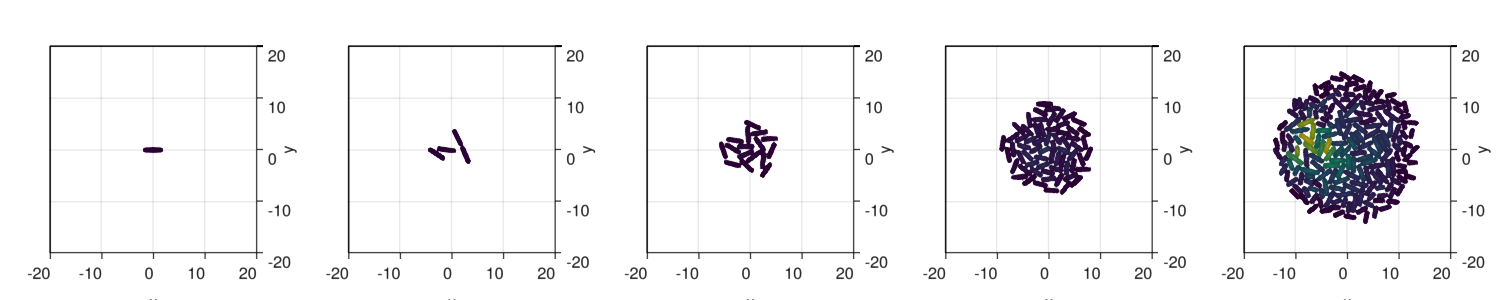

In [59]:
fig = Figure(resolution=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    CBMPlots.plotRods2D!(ax,com[j][:x],com[j][:y],com[j][:d],com[j][:l],com[j][:theta],
            color=com[j][:pressure], colorrange=(0,0.05))
    xlims!(-20,20)
    ylims!(-20,20)
end

display(fig)